In [1]:
!pip install --quiet pandas numpy matplotlib seaborn scikit-learn joblib imbalanced-learn geopandas 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 63.9 MB/s eta 0:00:00:00:010:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import gc
import joblib
import os

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
os.makedirs("/kaggle/working/eda", exist_ok=True)
os.makedirs("/kaggle/working/models", exist_ok=True)

In [4]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory reduced from {start_mem:.2f} MB to {end_mem:.2f} MB")
    return df

In [5]:
drought_df = pd.read_csv("/kaggle/input/united-states-droughts-by-county/us-droughts.csv", low_memory=False)
county_df = pd.read_csv("/kaggle/input/united-states-droughts-by-county/county_info_2016.csv", encoding="latin1", low_memory=False)

In [6]:
drought_df["FIPS"] = drought_df["FIPS"].astype(str).str.zfill(5)
county_df["GEOID"] = county_df["GEOID"].astype(str).str.zfill(5)

In [7]:
merged_df = drought_df.merge(county_df, left_on="FIPS", right_on="GEOID", how="inner")

In [8]:
merged_df = reduce_mem_usage(merged_df)

Memory reduced from 495.58 MB to 309.74 MB


In [9]:
date_cols = ["releaseDate", "validStart", "validEnd"]
for col in date_cols:
    merged_df[col] = pd.to_datetime(merged_df[col], errors="coerce")
    merged_df[f"{col}_year"] = merged_df[col].dt.year.astype("Int16")
    merged_df[f"{col}_month"] = merged_df[col].dt.month.astype("Int8")
    merged_df[f"{col}_week"] = merged_df[col].dt.isocalendar().week.astype("Int8")

In [10]:
merged_df.drop(columns=date_cols, inplace=True)

In [11]:
print(merged_df.columns.tolist())

['FIPS', 'county', 'state', 'NONE', 'D0', 'D1', 'D2', 'D3', 'D4', 'domStatisticFormatID', 'USPS', 'GEOID', 'ANSICODE', 'NAME', 'ALAND', 'AWATER', 'ALAND_SQMI', 'AWATER_SQMI', 'INTPTLAT', 'INTPTLONG                                                                                                               ', 'releaseDate_year', 'releaseDate_month', 'releaseDate_week', 'validStart_year', 'validStart_month', 'validStart_week', 'validEnd_year', 'validEnd_month', 'validEnd_week']


In [12]:
merged_df.columns = merged_df.columns.str.strip()

In [13]:
selected_columns = [
    # Target variables
    "NONE", "D0", "D1", "D2", "D3", "D4",
    # Location features
    "state", "USPS", "ALAND_SQMI", "AWATER_SQMI", "INTPTLAT", "INTPTLONG",
    # Temporal features
    "releaseDate_year", "releaseDate_month", "releaseDate_week",
    # Possibly useful identifier
    "FIPS"
]
reduced_df = merged_df[selected_columns].copy()

In [14]:
reduced_df.to_csv("/kaggle/working/cleaned_data.csv", index=False)
print("✅ Cleaned data saved.")

✅ Cleaned data saved.


In [15]:
import psutil

mem = psutil.virtual_memory()
print(f"💾 Used: {mem.used / 1024**2:.2f} MB")
print(f"📦 Available: {mem.available / 1024**2:.2f} MB")
print(f"💻 Total: {mem.total / 1024**2:.2f} MB")

💾 Used: 2166.17 MB
📦 Available: 29479.43 MB
💻 Total: 32102.90 MB


In [16]:
eda_sample = reduced_df.sample(n=100_000, random_state=42)

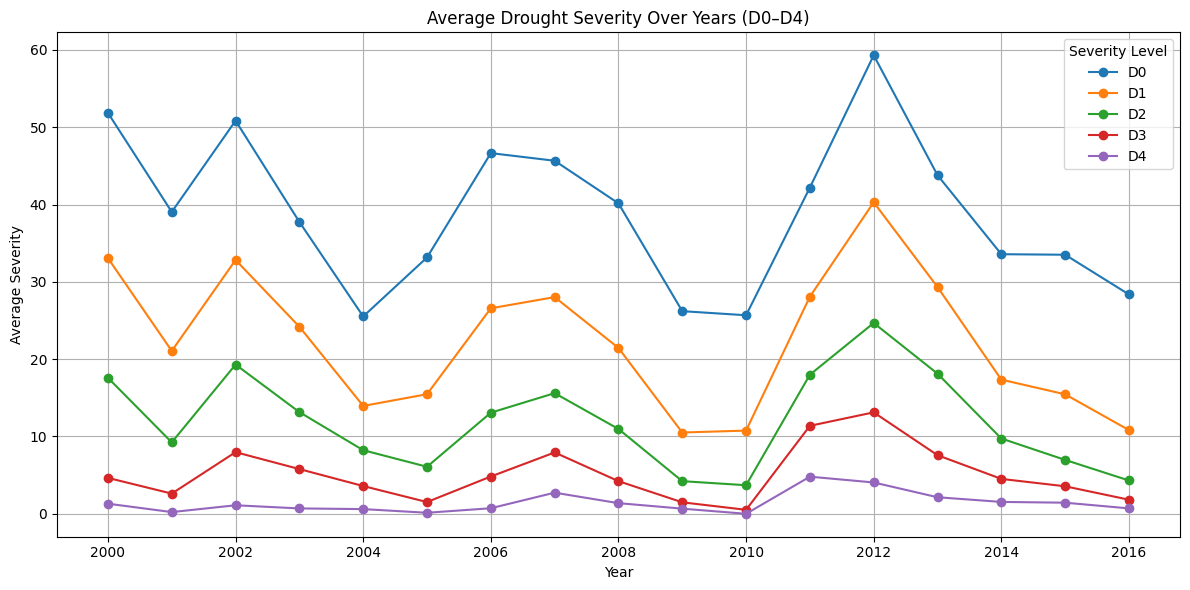

In [17]:
# Ensure year is integer and drought columns are float32
eda_sample['releaseDate_year'] = eda_sample['releaseDate_year'].astype(int)
severity_cols = ['D0', 'D1', 'D2', 'D3', 'D4']
eda_sample[severity_cols] = eda_sample[severity_cols].astype('float32')

# Plot drought severity trends over the years
plt.figure(figsize=(12, 6))
for col in severity_cols:
    yearly_avg = eda_sample.groupby('releaseDate_year')[col].mean()
    plt.plot(yearly_avg.index, yearly_avg.values, marker='o', label=col)

plt.title("Average Drought Severity Over Years (D0–D4)")
plt.xlabel("Year")
plt.ylabel("Average Severity")
plt.legend(title="Severity Level")
plt.grid(True)
plt.tight_layout()
plt.savefig("/kaggle/working/eda/drought_severity_trends_yearly.png")
plt.show()
plt.close()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


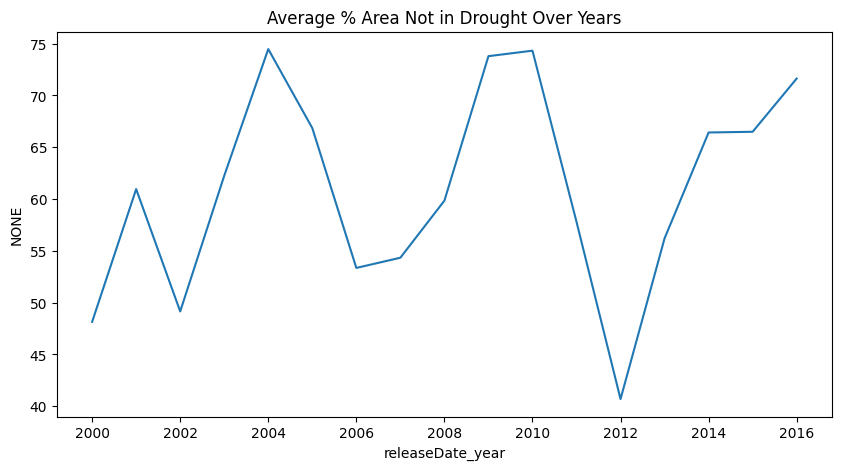

In [18]:
# Line plot: Average NONE over time
plt.figure(figsize=(10,5))
sns.lineplot(data=eda_sample.groupby("releaseDate_year")["NONE"].mean().reset_index(),
             x="releaseDate_year", y="NONE")
plt.title("Average % Area Not in Drought Over Years")
plt.savefig("/kaggle/working/eda/d0_trend.png")
plt.show()
plt.close()

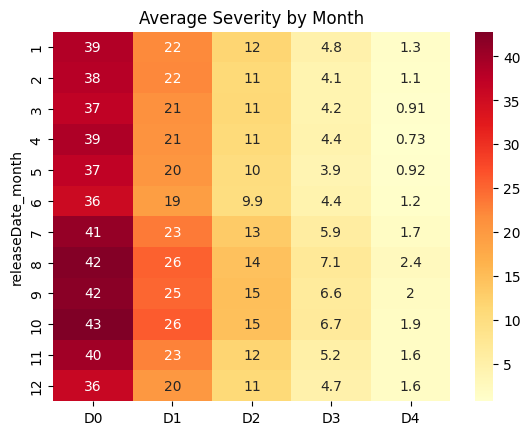

In [19]:
# Heatmap: Month vs Severity
month_severity = eda_sample.groupby("releaseDate_month")[["D0","D1","D2","D3","D4"]].mean()
sns.heatmap(month_severity, cmap="YlOrRd", annot=True)
plt.title("Average Severity by Month")
plt.savefig("/kaggle/working/eda/d0_trend.png")
plt.show()
plt.close()

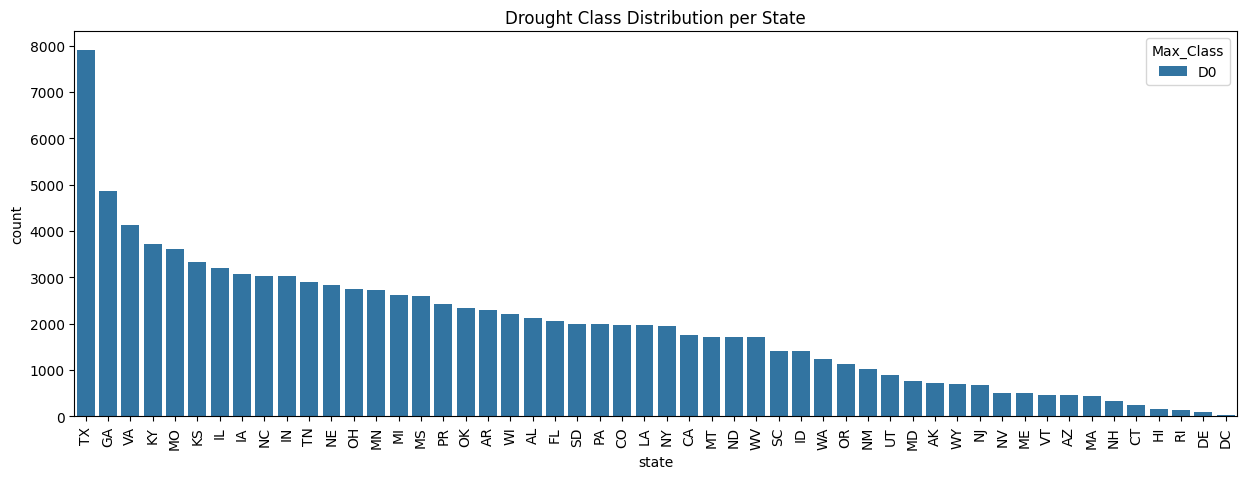

In [20]:
# Countplot: Drought severity class per state
eda_sample["Max_Class"] = eda_sample[["D0","D1","D2","D3","D4"]].idxmax(axis=1)
plt.figure(figsize=(15,5))
sns.countplot(data=eda_sample, x="state", hue="Max_Class", order=eda_sample["state"].value_counts().index)
plt.xticks(rotation=90)
plt.title("Drought Class Distribution per State")
plt.savefig("/kaggle/working/eda/d0_trend.png")
plt.show()
plt.close()

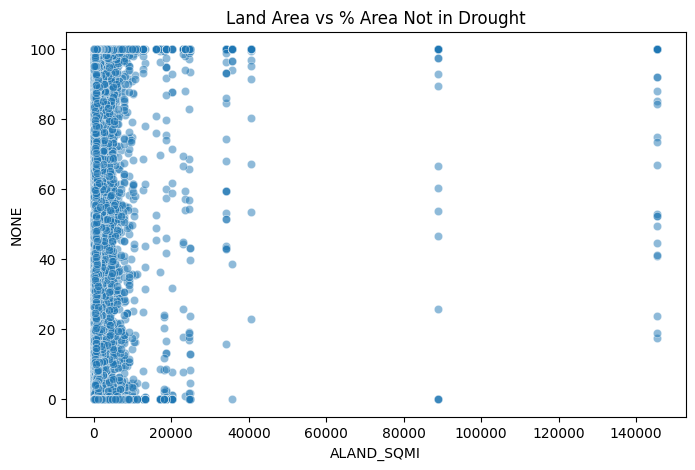

In [21]:
# Scatter: ALAND_SQMI vs NONE
plt.figure(figsize=(8,5))
sns.scatterplot(data=eda_sample, x="ALAND_SQMI", y="NONE", alpha=0.5)
plt.title("Land Area vs % Area Not in Drought")
plt.savefig("/kaggle/working/eda/d0_trend.png")
plt.show()
plt.close()

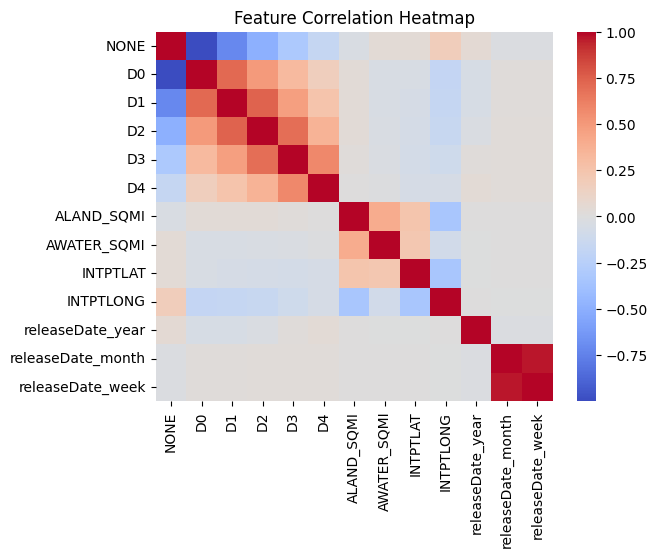

In [22]:
# Correlation heatmap
corr = eda_sample.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.savefig("/kaggle/working/eda/d0_trend.png")
plt.show()
plt.close()

<Figure size 800x500 with 0 Axes>

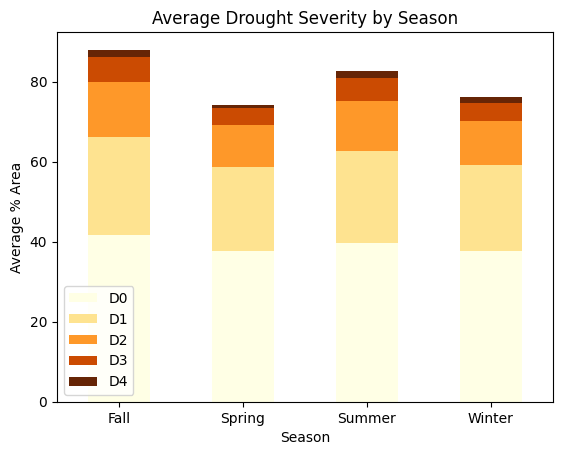

In [23]:
# Seasonal drought severity trend
season_map = {12: 'Winter', 1: 'Winter', 2: 'Winter',
              3: 'Spring', 4: 'Spring', 5: 'Spring',
              6: 'Summer', 7: 'Summer', 8: 'Summer',
              9: 'Fall', 10: 'Fall', 11: 'Fall'}

eda_sample["Season"] = eda_sample["releaseDate_month"].map(season_map)
season_severity = eda_sample.groupby("Season")[["D0","D1","D2","D3","D4"]].mean().reset_index()

plt.figure(figsize=(8,5))
season_severity.plot(x="Season", kind="bar", stacked=True, colormap="YlOrBr")
plt.title("Average Drought Severity by Season")
plt.ylabel("Average % Area")
plt.xticks(rotation=0)
plt.savefig("/kaggle/working/eda/d0_trend.png")
plt.show()
plt.close()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


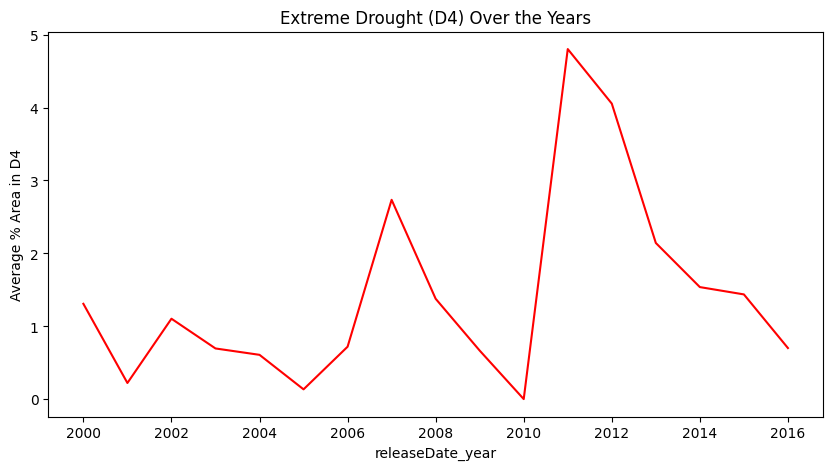

In [24]:
# Yearly trend in extreme drought (D4)
plt.figure(figsize=(10,5))
sns.lineplot(
    data=eda_sample.groupby("releaseDate_year")["D4"].mean().reset_index(),
    x="releaseDate_year", y="D4", color="red"
)
plt.title("Extreme Drought (D4) Over the Years")
plt.ylabel("Average % Area in D4")
plt.savefig("/kaggle/working/eda/d0_trend.png")
plt.show()
plt.close()

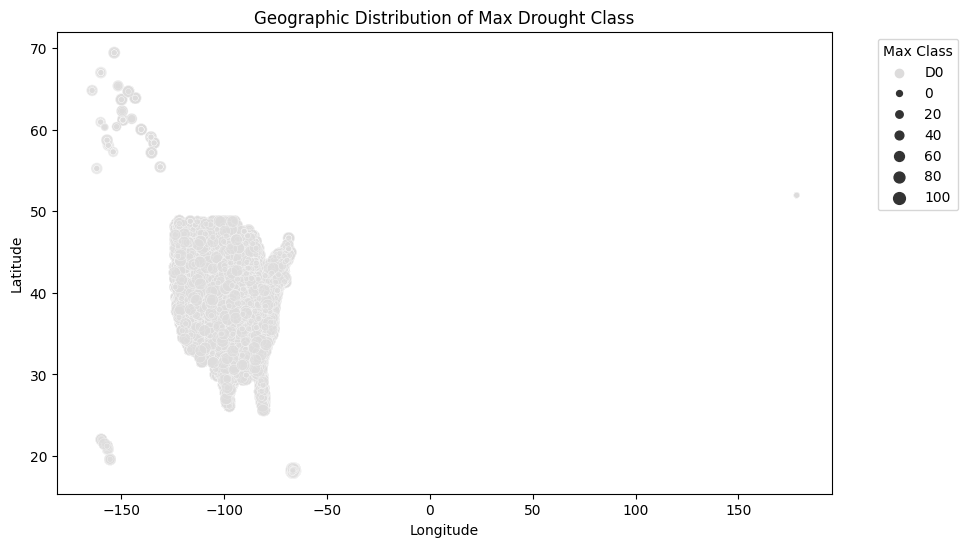

In [25]:
# Geo scatter plot: location vs severity
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=eda_sample,
    x="INTPTLONG", y="INTPTLAT",
    size=eda_sample[["D0","D1","D2","D3","D4"]].max(axis=1),
    hue="Max_Class",
    alpha=0.6,
    palette="coolwarm"
)
plt.title("Geographic Distribution of Max Drought Class")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Max Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("/kaggle/working/eda/d0_trend.png")
plt.show()
plt.close()

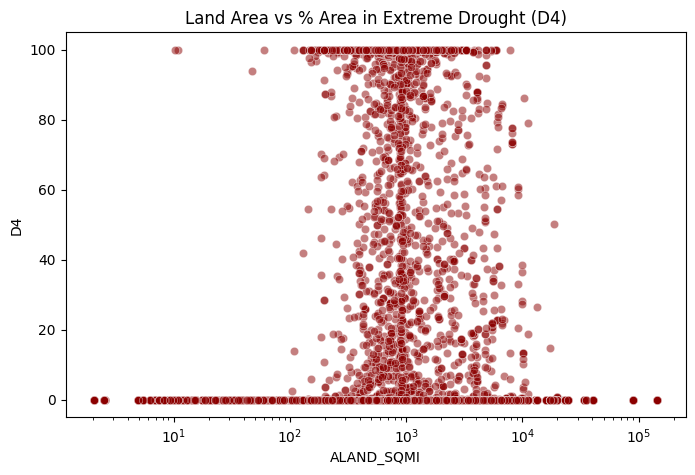

In [26]:
# Relationship between land area and extreme drought
plt.figure(figsize=(8,5))
sns.scatterplot(data=eda_sample, x="ALAND_SQMI", y="D4", alpha=0.5, color="darkred")
plt.xscale("log")  # Log scale for spread clarity
plt.title("Land Area vs % Area in Extreme Drought (D4)")
plt.savefig("/kaggle/working/eda/d0_trend.png")
plt.show()
plt.close()

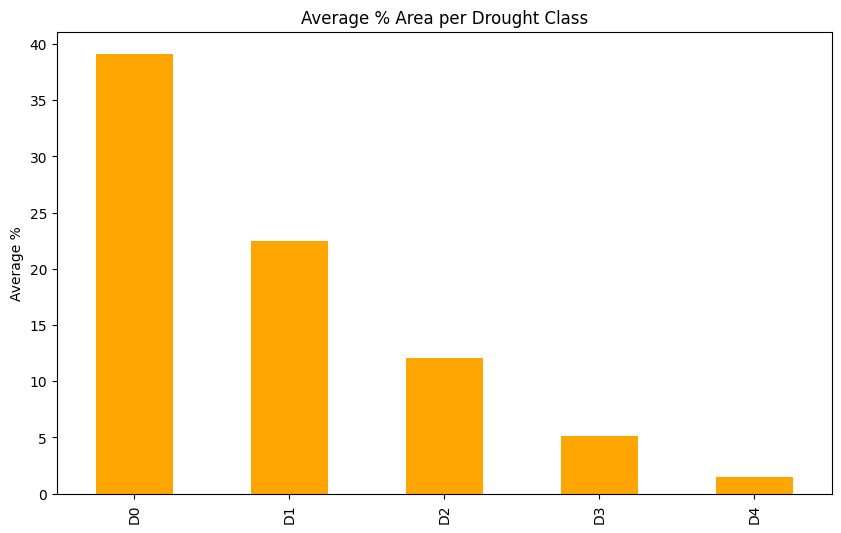

In [27]:
# Distribution of drought severity values
plt.figure(figsize=(10,6))
eda_sample[["D0","D1","D2","D3","D4"]].mean().plot(kind="bar", color="orange")
plt.title("Average % Area per Drought Class")
plt.ylabel("Average %")
plt.savefig("/kaggle/working/eda/d0_trend.png")
plt.show()
plt.close()

In [28]:

# Define target as the max drought class
reduced_df["Max_Class"] = reduced_df[["D0", "D1", "D2", "D3", "D4"]].idxmax(axis=1)

# Encode categorical vars
le_state = LabelEncoder()
reduced_df["state"] = le_state.fit_transform(reduced_df["state"])
reduced_df["USPS"] = LabelEncoder().fit_transform(reduced_df["USPS"])

# Features and target
X = reduced_df.drop(columns=["Max_Class"])
y = reduced_df["Max_Class"]


In [29]:
# Identify numeric columns (excluding categorical IDs)
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Compute IQR bounds
Q1 = X[numeric_cols].quantile(0.25)
Q3 = X[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Clip values outside the bounds
X_capped = X.copy()
for col in numeric_cols:
    X_capped[col] = X_capped[col].clip(lower=lower_bound[col], upper=upper_bound[col])

print("✅ Outliers handled via capping (no rows dropped).")


✅ Outliers handled via capping (no rows dropped).


In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X_capped, y, test_size=0.2, random_state=42
)

In [31]:
# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("✅ Feature scaling complete.")


✅ Feature scaling complete.


Before balancing: Counter({'D0': 2259376, 'D1': 5})


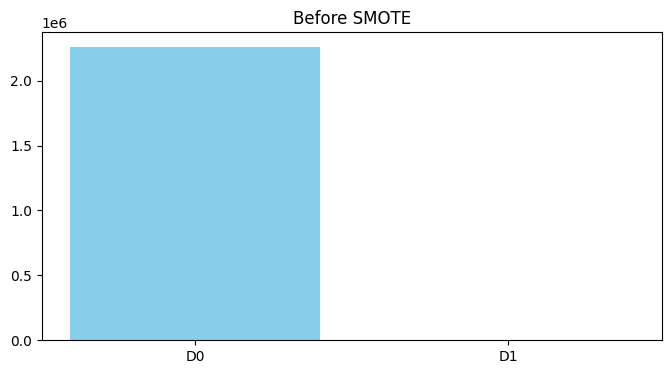

In [32]:
from collections import Counter

os.makedirs("/kaggle/working/plots", exist_ok=True)

counter_before = Counter(y_train)

print("Before balancing:", Counter(y_train))

plt.figure(figsize=(8,4))
plt.bar(Counter(y_train).keys(), Counter(y_train).values(), color='skyblue')
plt.title("Before SMOTE")
plt.savefig("/kaggle/working/plots/before_smote.png", dpi=300)
plt.show()
plt.close()

In [33]:
# Step 1: SMOTE with very low k_neighbors
smote = SMOTE(sampling_strategy=0.1, random_state=42, k_neighbors=1)  # 0.1 means minority will be 10% of majority
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

from imblearn.over_sampling import RandomOverSampler

# Step 2: Random oversampling to further boost minority class
ros = RandomOverSampler(sampling_strategy=0.2, random_state=42)  # final 20% minority ratio
X_train_res, y_train_res = ros.fit_resample(X_train_sm, y_train_sm)

After balancing: Counter({'D0': 2259376, 'D1': 451875})


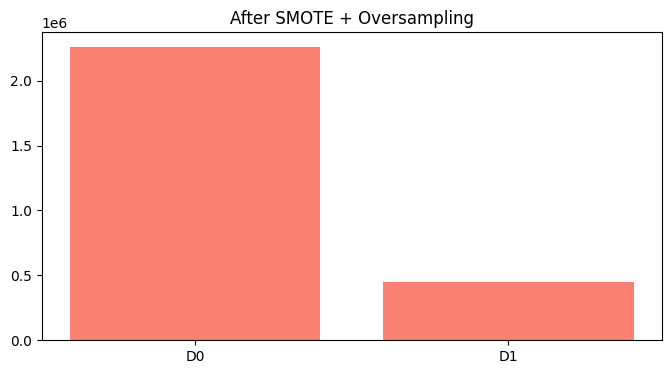

✅ SMOTE + Oversampling done.


In [34]:
print("After balancing:", Counter(y_train_res))

plt.figure(figsize=(8,4))
plt.bar(Counter(y_train_res).keys(), Counter(y_train_res).values(), color='salmon')
plt.title("After SMOTE + Oversampling")
plt.savefig("/kaggle/working/plots/after_smote.png", dpi=300)
plt.show()

print("✅ SMOTE + Oversampling done.")

In [35]:
import psutil

mem = psutil.virtual_memory()
print(f"💾 Used: {mem.used / 1024**2:.2f} MB")
print(f"📦 Available: {mem.available / 1024**2:.2f} MB")
print(f"💻 Total: {mem.total / 1024**2:.2f} MB")

💾 Used: 3539.42 MB
📦 Available: 28106.19 MB
💻 Total: 32102.90 MB


In [36]:
try:
    from lightgbm import LGBMClassifier
except:
    LGBMClassifier = None
try:
    from xgboost import XGBClassifier
except:
    XGBClassifier = None

os.makedirs("/kaggle/working/models", exist_ok=True)
os.makedirs("/kaggle/working/plots", exist_ok=True)

In [37]:
# Convert data to float32
def ensure_numpy_float32(X):
    if hasattr(X, "values"):
        X = X.values
    return np.asarray(X, dtype=np.float32)

X_train_res = ensure_numpy_float32(X_train_res)
X_test = ensure_numpy_float32(X_test)

In [38]:
# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(["NONE", "D0", "D1", "D2", "D3", "D4"])

y_train_enc = label_encoder.transform(np.asarray(y_train_res).astype(str))
y_test_enc = label_encoder.transform(np.asarray(y_test).astype(str))

print("Classes:", label_encoder.classes_)
print("Train class counts:", Counter(y_train_enc))


Classes: ['D0' 'D1' 'D2' 'D3' 'D4' 'NONE']
Train class counts: Counter({0: 2259376, 1: 451875})


In [39]:
# Subsample for tuning only
MAX_TUNE_SAMPLES = 200_000
if X_train_res.shape[0] > MAX_TUNE_SAMPLES:
    print(f"Subsampling {MAX_TUNE_SAMPLES} rows for tuning...")
    rng = np.random.RandomState(42)
    idx = rng.choice(X_train_res.shape[0], MAX_TUNE_SAMPLES, replace=False)
    X_tune, y_tune = X_train_res[idx], y_train_enc[idx]
else:
    X_tune, y_tune = X_train_res, y_train_enc

Subsampling 200000 rows for tuning...


In [40]:
# Randomized search helper
def small_random_search(estimator, param_distributions, X, y, n_iter=8, cv=3):
    cvobj = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    rs = RandomizedSearchCV(estimator, param_distributions, n_iter=n_iter, scoring='accuracy',
                            cv=cvobj, random_state=42, n_jobs=1)
    rs.fit(X, y)
    return rs.best_params_

results = {}


In [41]:
# --- Decision Tree ---

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split

print("\nTuning Decision Tree...")
dt_params = {"max_depth": [6, 8, 10, None], "min_samples_leaf": [1, 5, 10, 20]}
best_params = small_random_search(DecisionTreeClassifier(random_state=42), dt_params, X_tune, y_tune)
best_dt = DecisionTreeClassifier(random_state=42, **best_params)
best_dt.fit(X_train_res, y_train_enc)
results['DecisionTree'] = best_dt
joblib.dump(best_dt, "/kaggle/working/DecisionTree_model.joblib", compress=3)
print("Saved Decision Tree model.")
gc.collect()


Tuning Decision Tree...
Saved Decision Tree model.


23

In [42]:
# --- Random Forest ---
print("\nTuning Random Forest...")
rf_params = {"n_estimators": [50, 100, 150], "max_depth": [8, 12, None], "min_samples_leaf": [1, 5, 10]}
best_params = small_random_search(RandomForestClassifier(random_state=42, n_jobs=1, class_weight='balanced'),
                                  rf_params, X_tune, y_tune)
best_rf = RandomForestClassifier(random_state=42, n_jobs=1, class_weight='balanced', **best_params)
best_rf.fit(X_train_res, y_train_enc)
results['RandomForest'] = best_rf
joblib.dump(best_rf, "/kaggle/working/RandomForest_model.joblib", compress=3)
print("Saved Random Forest model.")
gc.collect()


Tuning Random Forest...
Saved Random Forest model.


0

In [44]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import gc
import joblib
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


# Encode labels if not already encoded
le = LabelEncoder()
y_tune_enc = le.fit_transform(y_tune)
y_train_enc = le.transform(y_train_enc)  # assuming y_train_enc is the raw labels for training

num_classes = len(np.unique(y_tune_enc))

if LGBMClassifier:
    print("\nTuning LightGBM...")
    lgb_params = {
        "num_leaves": [31, 63],
        "n_estimators": [100, 200],
        "learning_rate": [0.1, 0.05],
    }

    best_params = small_random_search(
        LGBMClassifier(objective='multiclass', n_jobs=1, random_state=42, num_class=num_classes),
        lgb_params, X_tune, y_tune_enc
    )

    best_lgb = LGBMClassifier(
        objective='multiclass',
        n_jobs=1,
        random_state=42,
        num_class=num_classes,
        **best_params
    )

    X_train_lgb, X_val_lgb, y_train_lgb, y_val_lgb = train_test_split(
        X_train_res, y_train_enc,
        test_size=0.15,
        stratify=y_train_enc,
        random_state=42
    )

    best_lgb.fit(
        X_train_lgb, y_train_lgb,
        eval_set=[(X_val_lgb, y_val_lgb)],
        callbacks=[lgb.early_stopping(stopping_rounds=20)],
        
    )

    results['LightGBM'] = best_lgb
    joblib.dump(best_lgb, "/kaggle/working/LightGBM_model.joblib", compress=3)
    print("Saved LightGBM model.")

    del X_train_lgb, X_val_lgb, y_train_lgb, y_val_lgb
    gc.collect()



Tuning LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3280
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 13
[LightGBM] [Info] Start training from score -0.180926
[LightGBM] [Info] Start training from score -1.798766
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 13
[LightGBM] [Info] Start training from score -0.180917
[LightGBM] [Info] Start training from score -1.798812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [45]:
# --- Evaluate & pick best ---

from sklearn.metrics import accuracy_score

print("\nEvaluating all models on test set...")
eval_summary = []

for name, model in results.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred)
    eval_summary.append((name, acc, model))
    print(f"{name:15s} Accuracy: {acc * 100:.2f}%")



Evaluating all models on test set...
DecisionTree    Accuracy: 99.99%
RandomForest    Accuracy: 100.00%
LightGBM        Accuracy: 100.00%


In [46]:
# best model
best_model_name = 'RandomForest'
best_acc = next(acc for name, acc, _ in eval_summary if name == best_model_name)
best_model = next(model for name, _, model in eval_summary if name == best_model_name)

print(f"\nBest Model: {best_model_name} with Accuracy: {best_acc:.4f}")

# Save best model + encoder (make sure label_encoder is the correct encoder variable)
joblib.dump({"model": best_model, "label_encoder": le},
            "/kaggle/working/best_drought_model.joblib", compress=3)
print(f"Saved best model to /kaggle/working/best_drought_model.joblib")

print("\nDone ✅")



Best Model: RandomForest with Accuracy: 1.0000
Saved best model to /kaggle/working/best_drought_model.joblib

Done ✅


In [ ]:
import shutil

# Zip the entire /kaggle/working directory into working_files.zip
shutil.make_archive('/kaggle/working/working_files', 'zip', '/kaggle/working')